# First order methods for regression models

## Aim

The aim of this material is to code 
- gradient descent (GD)
- accelerated gradient descent (AGD)
- coordinate gradient descent (CD)
- stochastic gradient descent (SGD)
- stochastic variance reduced gradient descent (SVRG)


for the linear regression and logistic regression models, with the 
ridge penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work, using the **moodle platform**.
- This means that **each student in the pair sends the same file**

# Gentle reminder: no evaluation if you don't respect this EXACTLY

## To generate the name of your file, use the following

In [1]:
# Change here using your first and last names
fn1 = "Gustavo"
ln1 = "Castro"
fn2 = "Francisco"
ln2 = "Ribeiro"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_castro_gustavo_and_ribeiro_francisco.ipynb


# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Getting model weights

We'll start by generating sparse vectors and simulating data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

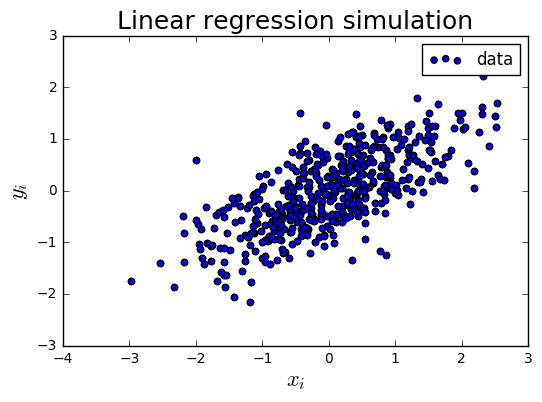

In [4]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

## 1.3. Simulation of a logistic regression model

In [5]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

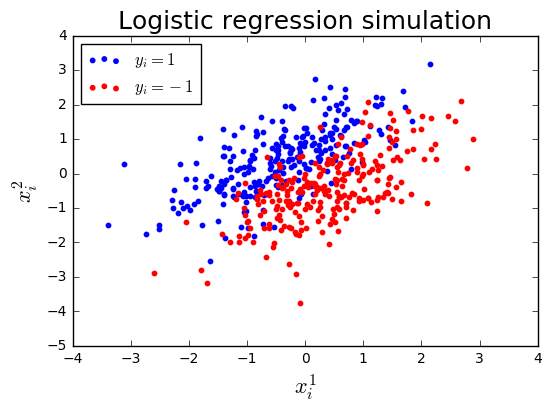

In [6]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.

Below is the full implementation for linear regression.

## 2.1 Linear regression

In [9]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()

## 2.2 Checks for the linear regression model

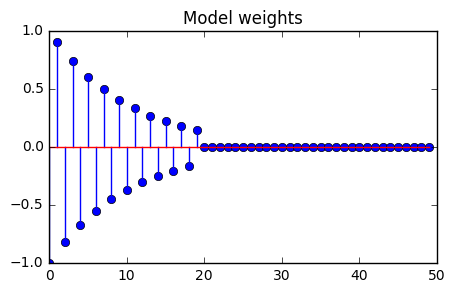

In [10]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w0 = (-1) ** (idx - 1) * np.exp(-idx / 10.)
w0[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0)
plt.title("Model weights")

In [11]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

1.75460648709e-06


In [12]:
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

('lip=', 4.2356748899097605)
('lip_max=', 124.35090608857803)
('lip_coordinates=', array([ 0.94,  0.97,  1.01,  0.95,  0.95,  0.99,  1.04,  1.01,  1.  ,
        1.04,  1.01,  0.97,  1.05,  1.01,  1.  ,  1.  ,  0.96,  0.97,
        0.94,  1.03,  1.05,  1.01,  1.01,  1.04,  1.05,  1.02,  0.96,
        1.07,  1.06,  1.1 ,  1.03,  1.08,  1.05,  1.  ,  1.05,  1.05,
        0.96,  0.97,  1.01,  0.95,  0.94,  1.01,  1.07,  1.08,  1.01,
        1.04,  0.96,  1.01,  0.99,  0.97]))


## 2.3 Logistic regression

**NB**: you can skip these questions and go to the solvers implementation, and come back here later.

### QUESTIONS

1. Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below (fill between the TODO and END TODO)

In [51]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        answer = 0
        for i in range(len(y)):
            answer += np.log(1+np.exp(-y[i]*X[i].dot(w)))
        return answer/n_samples + strength*norm(w)**2/2
        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        answer = np.array([0.]*len(w))
        for i in range(len(y)):
            auxexp = np.exp(-y[i]*X[i].dot(w))
            answer += -y[i]*auxexp/(1+auxexp)* X[i]
        return answer/len(y) + strength*w
        ### END TODO

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i], strength = self.strength
        ### TODO
        auxexp = np.exp(-y[i]*x_i.dot(w))
        answer = -y[i]*x_i*auxexp/(1+auxexp)
        return answer+ strength*w
        ### END TODO

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        answer = 0
        for i in range(len(y)):
            auxexp = np.exp(-y[i]*X[i].dot(w))
            answer += -y[i]*X[i][j]*auxexp/(1+auxexp)
        return answer/len(y) + strength*w[j]
        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of f"""
        X, n_samples = self.X, self.n_samples
        ### TODO

        ### END TODO

    def lip_coordinates(self):
        """Computes the Lipschitz constant of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        ### TODO
        
        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO

        ### END TODO

## 2.4 Checks for the logistic regression model

### QUESTIONS

1. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize`` (see below), as we did for linear regression above

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model

In [52]:
### TODO

X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

## check lips
print("lip=", model.lip())
print("lip_max=", model.lip_max())
print("lip_coordinates=", model.lip_coordinates())

### END TODO

1.48677821073e-06
('lip=', None)
('lip_max=', None)
('lip_coordinates=', None)



<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression.

We want now to code and compare several solvers to minimize $f$

<a id='tools'></a>
## 3.1. Tools for the solvers

In [15]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [16]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

1. Finish the function `gd` below that implements the gradient descent algorithm
- Test it using the next cell

In [ ]:
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        
        ### END TODO
        callback(w)
    return w

In [ ]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

1. Finish the function `agd` below that implements the accelerated gradient descent algorithm
- Test it using the next cell

In [ ]:
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration
    z = w0.copy()
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO

        ### END TODO        
        callback(w)
    return w

In [ ]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

<a id='cgd'></a>

## 3.4 Coordinate gradient descent

### QUESTIONS

1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm
- Test it using the next cell

In [ ]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO

        ### END TODO
        callback(w)
    return w

In [ ]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

<a id='sgd'></a>
## 3.5. Stochastic gradient descent

### QUESTIONS

- Finish the function `sgd` below that implements the st stochastic gradient descent algorithm
- Test it using the next cell

In [ ]:
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO

        ### END TODO
        if idx % n_samples == 0:
            callback(w)
    return w

In [ ]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

<a id='sag'></a>
## 3.6. Stochastic average gradient descent


### QUESTIONS

1. Finish the function `sag` below that implements the stochastic averaged gradient algorithm
- Test it using the next cell

In [ ]:
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO

        ### END OF TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [ ]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

### QUESTIONS

- Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm
- Test it using the next cell

In [ ]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    n_samples = model.n_samples
    callback(w)
    for idx in range(n_iter):        
        ### TODO

        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return 

In [ ]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

<a id='comparison'></a>
# 4. Comparison of all algorithms

In [ ]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

In [ ]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### QUESTIONS

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.
- (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization $f(w) = \lambda \sum_{j=1}^d |w_j|$